# Pairs Trading Strategy: Cointegration-Based Mean Reversion


## 1. Overview & Setup

Pairs trading exploits temporary mispricings between two cointegrated assets. When their
spread deviates significantly from the mean (measured via z-score), we trade the convergence.

**Strategy logic:**
1. Find cointegrated NIFTY stock pairs using Engle-Granger test
2. Compute normalized spread: $z_t = \frac{S_t - \mu_s}{\sigma_s}$
3. **Enter long-short** when |z| > entry threshold (e.g. ±2)
4. **Exit** when |z| < exit threshold (e.g. ±0.5)
5. Size positions inversely proportional to volatility

We'll backtest this on NIFTY 50 constituents over 7 years of daily data.


In [3]:
# Core imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 2. Data Acquisition: NIFTY 50 Constituents

We'll download **7 years** of daily adjusted close prices for all NIFTY 50 stocks,
then compute log returns and look for candidate pairs among the most liquid names.

Key data requirements:
- **Adjusted close prices** (dividends, splits handled)
- **7 years** for reliable cointegration tests
- **Daily frequency** for z-score signals


In [20]:
# NIFTY 50 symbols (liquid names)
nifty_symbols = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS',
    'ICICIBANK.NS', 'KOTAKBANK.NS', 'BHARTIARTL.NS', 'ITC.NS', 'SBIN.NS',
    'ASIANPAINT.NS', 'LT.NS', 'AXISBANK.NS', 'MARUTI.NS', 'ULTRACEMCO.NS',
    'NTPC.NS', 'NESTLEIND.NS', 'POWERGRID.NS', 'TITAN.NS', 'SUNPHARMA.NS',
    'TECHM.NS', 'TATAMOTORS.NS', 'WIPRO.NS', 'ONGC.NS', 'HCLTECH.NS',
    'BAJFINANCE.NS', 'HINDALCO.NS', 'COALINDIA.NS', 'JSWSTEEL.NS', 'DRREDDY.NS'
]

# Download data
data = yf.download(nifty_symbols, start='2018-01-01', end='2025-12-01', 
                   auto_adjust=True, progress=False)['Close']

# Data Cleaning
data = data.dropna(axis=1, thresh=int(0.95*len(data)))  # Drop bad stocks
data = data.fillna(method='ffill')  # Fill gaps

print(f"Clean data: {data.shape} ({len(data.columns)} stocks)")

Clean data: (1955, 30) (30 stocks)


<Figure size 1400x700 with 0 Axes>

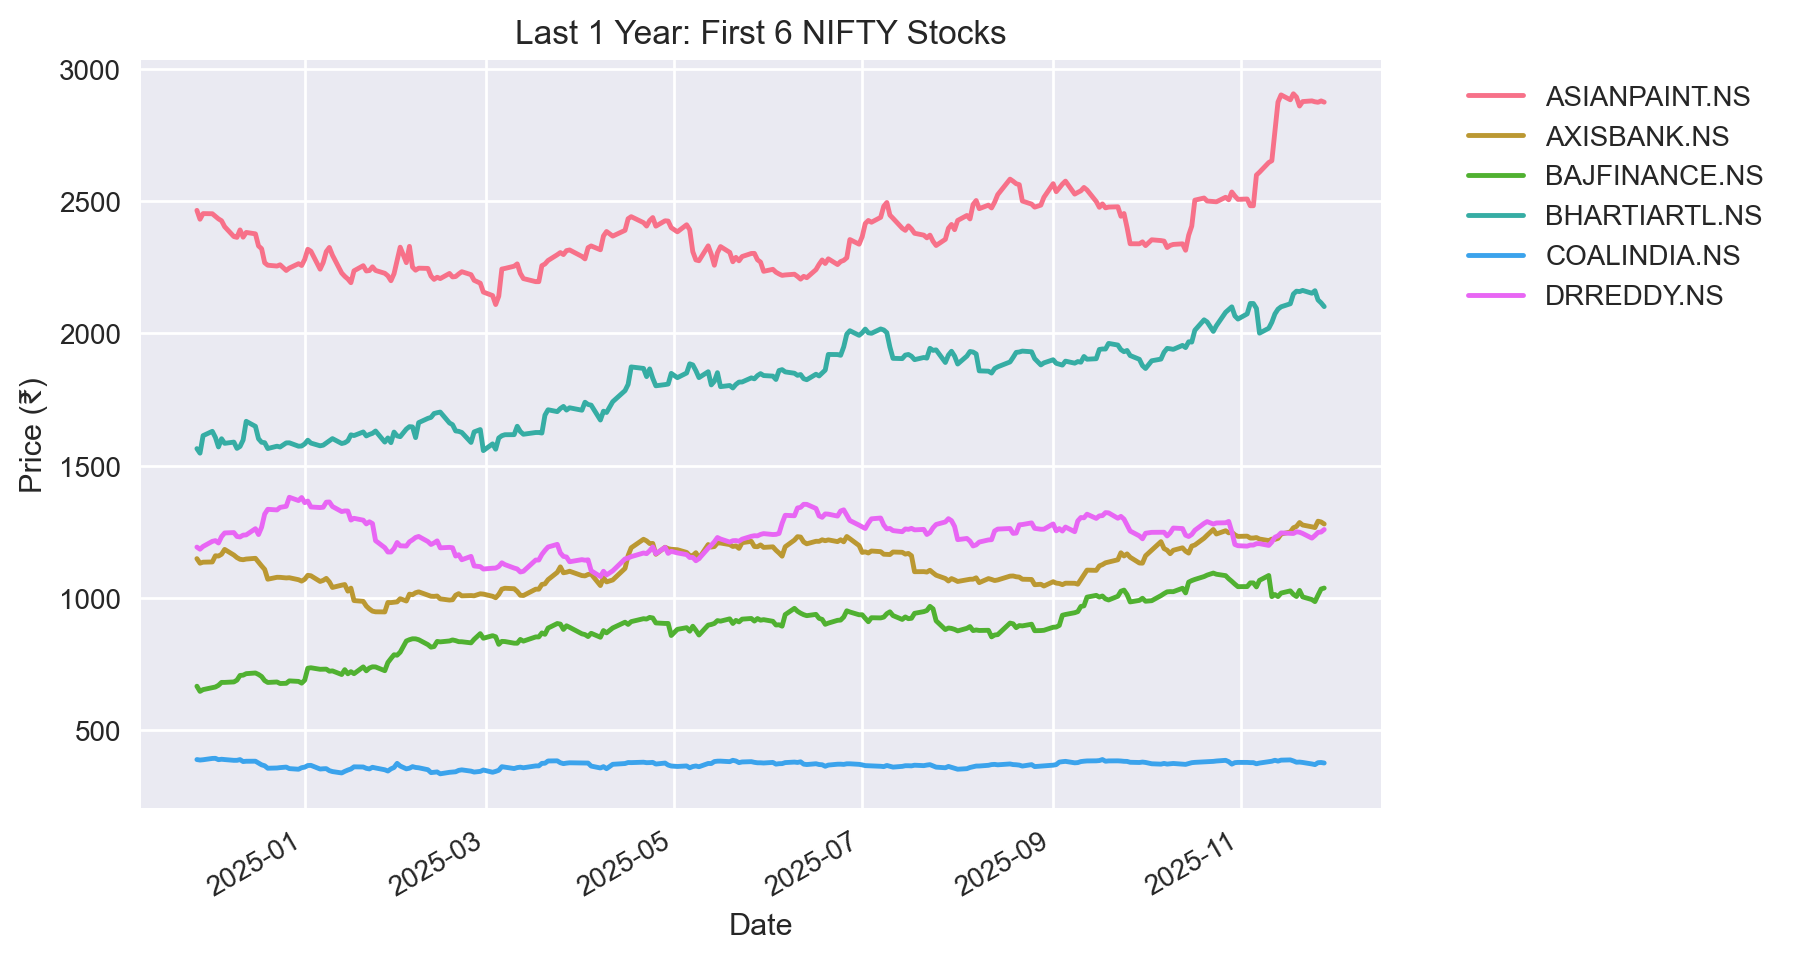

In [25]:
# Quick visual check: last 1 year of first 6 stocks
plt.figure(figsize=(14, 7))
data.iloc[-252:, :6].plot()
plt.title("Last 1 Year: First 6 NIFTY Stocks")
plt.ylabel("Price (₹)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.show()

## 3. Cointegration Screening: Finding Mean-Reverting Pairs

Test **all pairs** (435 combinations) using **Engle-Granger 2-step method**:

1. **Step 1:** OLS regression: $log(P_1) = α + β × log(P_2) + ε_t$
2. **Step 2:** ADF test on residuals $ε_t$ (p < 0.05 = cointegrated)

**Criteria:** p-value < 0.05 + |β| between 0.5-2.0 (reasonable hedge ratios)


In [40]:
from itertools import combinations


pairs = []

for s1, s2 in combinations(data.columns, 2):
    _, pval, _ = coint(data[s1], data[s2])
    if pval < 0.05:
        X = data[s2].values.reshape(-1, 1)
        y = data[s1].values
        beta = np.linalg.lstsq(X, y, rcond=None)[0][0]
        if 0.5 <= abs(beta) <= 2.0:
            pairs.append({"stock1": s1,
                "stock2": s2, "pair": f"{s1}-{s2}", "pvalue": pval, "beta": beta})

top_pairs = pd.DataFrame(pairs).sort_values("pvalue").head(5)
print("TOP 5 COINTEGRATED PAIRS:")
print(top_pairs[["pair", "pvalue", "beta"]].round(4))
print("Total cointegrated pairs:", len(pairs))

TOP 5 COINTEGRATED PAIRS:
                         pair  pvalue    beta
3        COALINDIA.NS-ONGC.NS  0.0063  1.4791
16            NTPC.NS-ONGC.NS  0.0081  1.2865
2        COALINDIA.NS-NTPC.NS  0.0090  1.1432
9     HINDALCO.NS-JSWSTEEL.NS  0.0093  0.6660
1   BAJFINANCE.NS-HDFCBANK.NS  0.0117  0.8379
Total cointegrated pairs: 18


## 4. Best Pair Selection & Spread Construction

**Select the top cointegrated pair** (lowest Engle-Granger p-value) from 435 combinations and construct:

- **Spread:** $S_t = log(S_1) - β × log(S_2)$
- **Z-score:** $z_t = \frac{S_t - \mu_s}{\sigma_s}$


In [41]:
# Pick the best pair (smallest p-value)
best = top_pairs.iloc[0]
s1, s2 = best["stock1"], best["stock2"]
beta = best["beta"]

print("Selected pair:", s1, "vs", s2)
print(f"Hedge ratio β = {beta:.3f}, p-value = {best['pvalue']:.4f}")

# Spread: log(S1) − beta * log(S2)
spread = np.log(data[s1]) - beta * np.log(data[s2])

# Z-score of the spread
spread_mean = spread.mean()
spread_std = spread.std()
zscore = (spread - spread_mean) / spread_std

print(f"Spread mean = {spread_mean:.4f}, std = {spread_std:.4f}")


Selected pair: COALINDIA.NS vs ONGC.NS
Hedge ratio β = 1.479, p-value = 0.0063
Spread mean = -2.0097, std = 0.2174


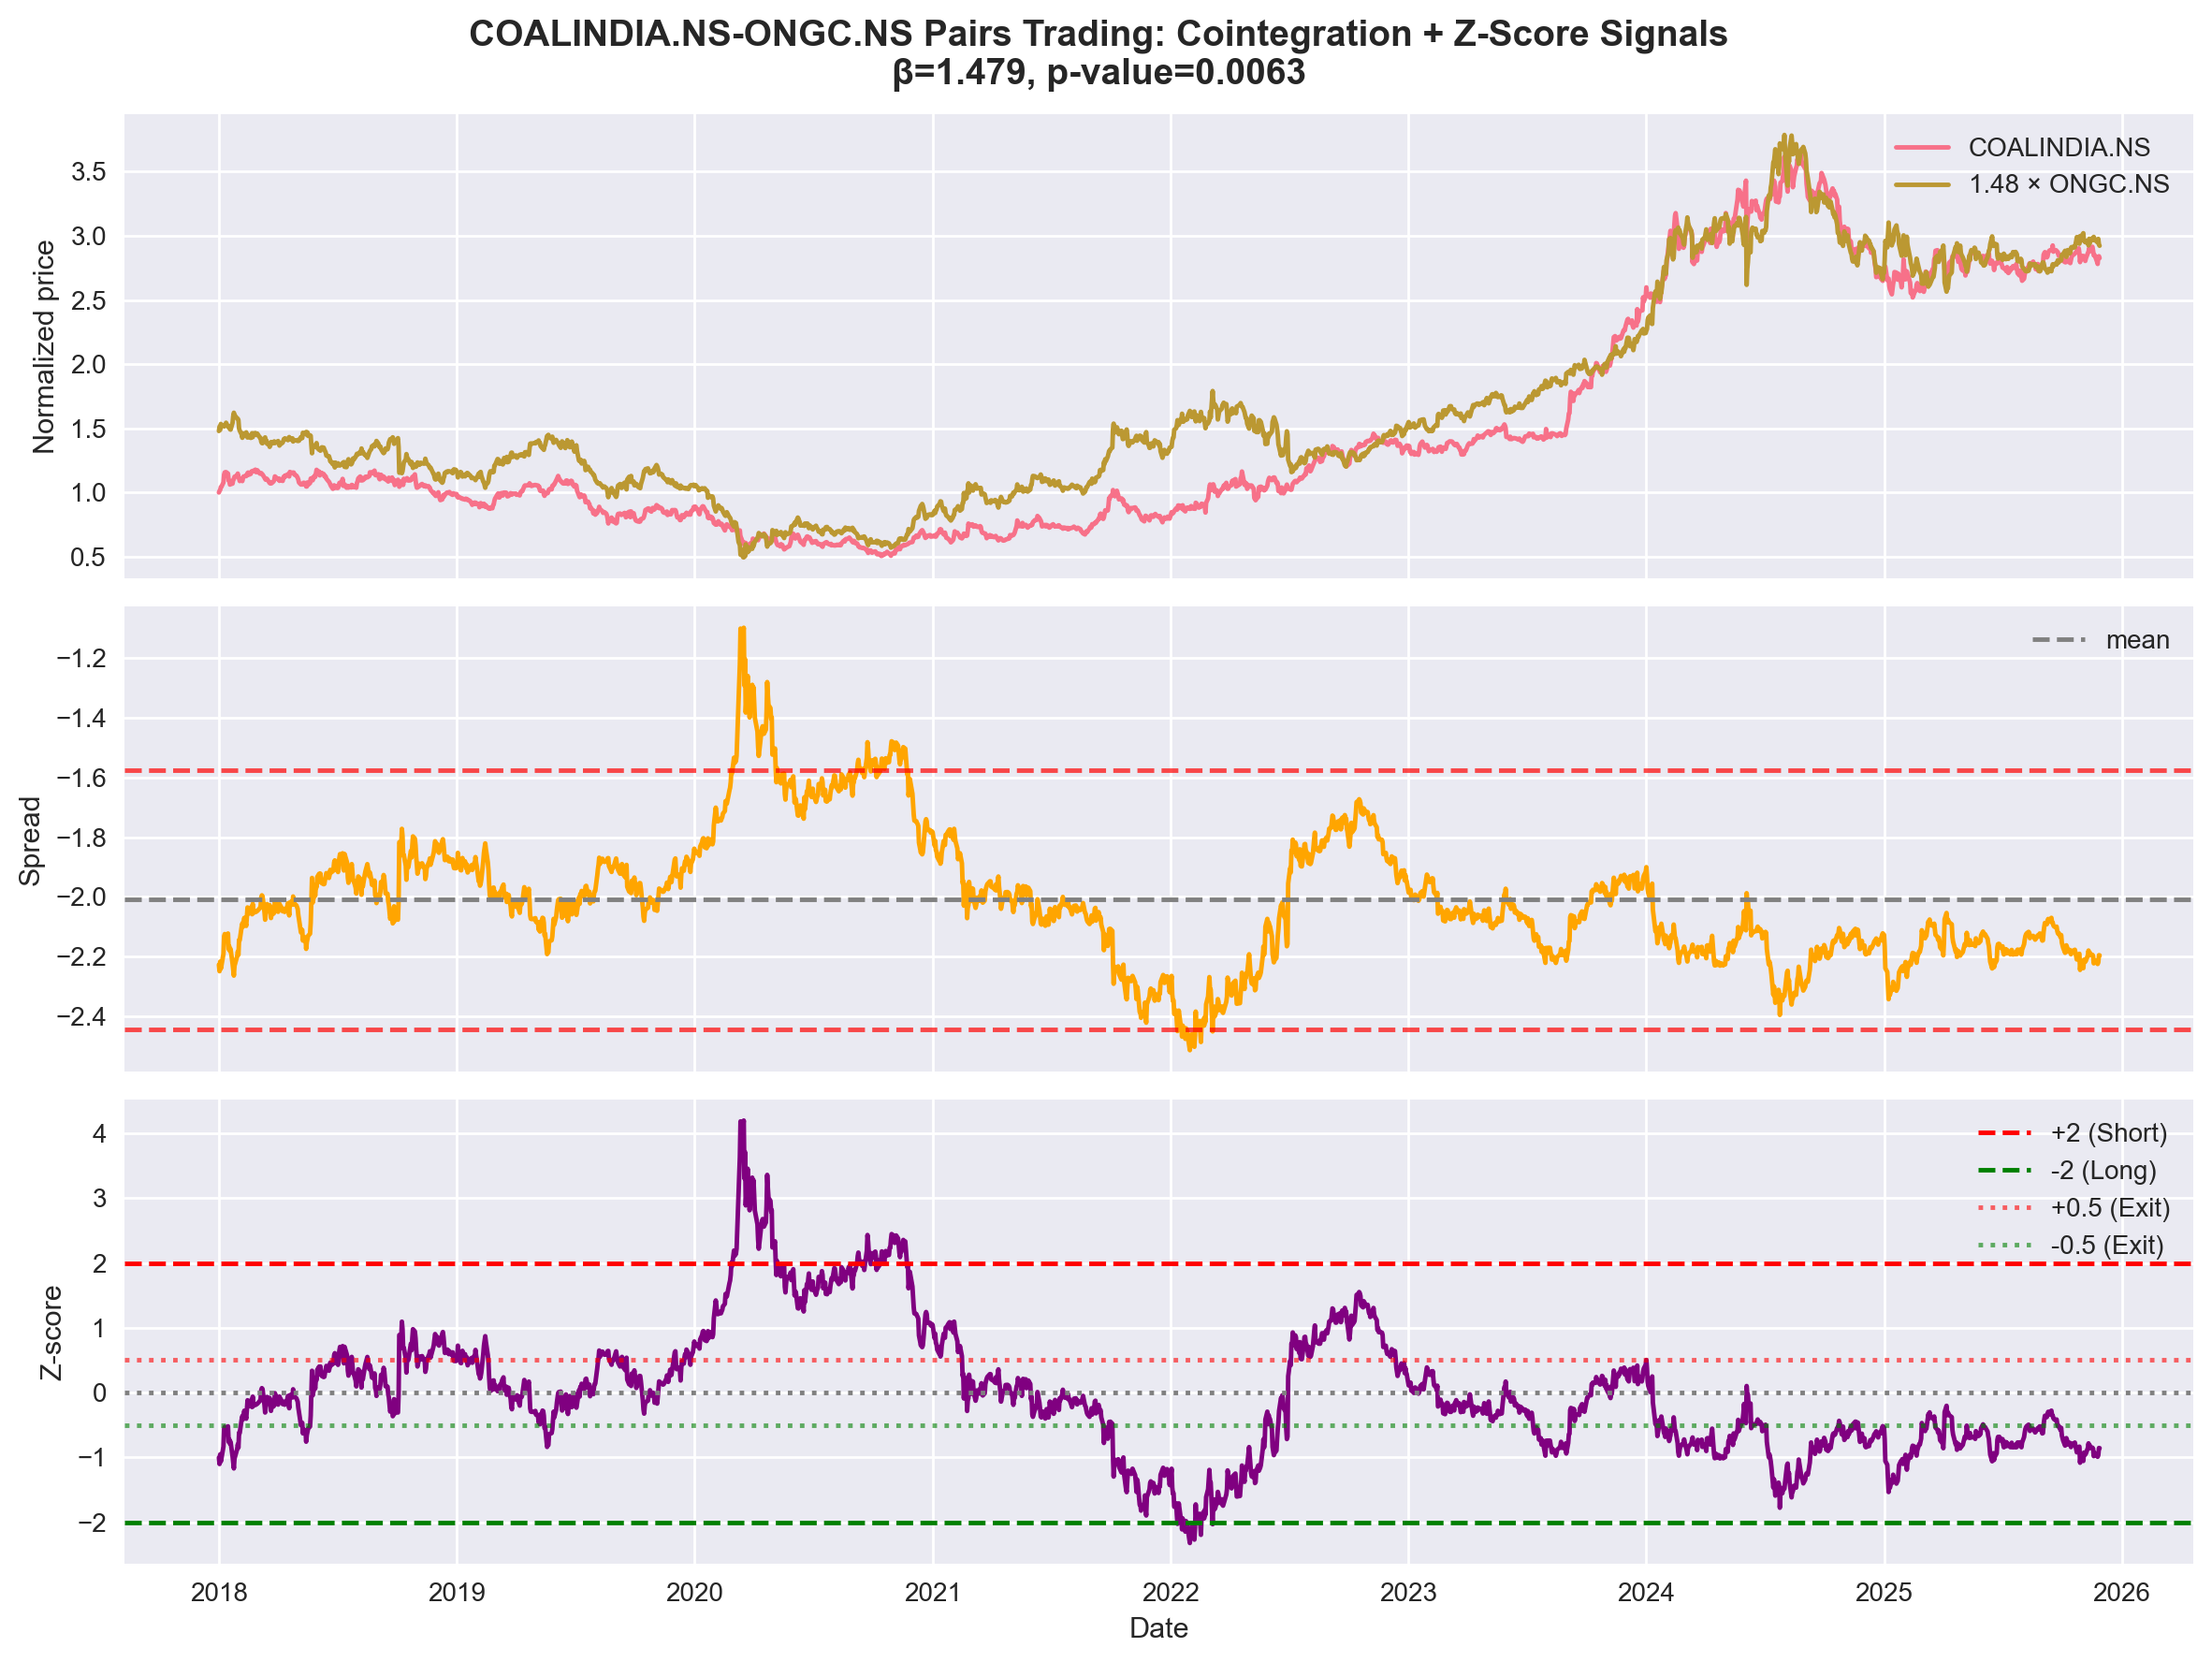

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# 1) Normalized prices
ax1.plot(data.index, data[s1] / data[s1].iloc[0], label=s1)
ax1.plot(data.index, beta * data[s2] / data[s2].iloc[0], label=f"{beta:.2f} × {s2}")
ax1.set_ylabel("Normalized price")
ax1.legend()
ax1.grid(True)

# 2) Spread
ax2.plot(spread.index, spread, color="orange")
ax2.axhline(spread_mean, color="gray", linestyle="--", label="mean")
ax2.axhline(spread_mean + 2 * spread_std, color="red", linestyle="--", alpha=0.7)
ax2.axhline(spread_mean - 2 * spread_std, color="red", linestyle="--", alpha=0.7)
ax2.set_ylabel("Spread")
ax2.legend()
ax2.grid(True)

# 3) Z-score (signals)
ax3.plot(zscore.index, zscore, color="purple")
ax3.axhline(2.0, color="red", linestyle="--", label="+2 (Short)")
ax3.axhline(-2.0, color="green", linestyle="--", label="-2 (Long)")
ax3.axhline(0.5, color='red', linestyle=':', alpha=0.6, label='+0.5 (Exit)')
ax3.axhline(-0.5, color='green', linestyle=':', alpha=0.6, label='-0.5 (Exit)')
ax3.axhline(0.0, color="gray", linestyle=":")
ax3.set_ylabel("Z-score")
ax3.set_xlabel("Date")
ax3.legend()
ax3.grid(True)

plt.suptitle(f'{s1}-{s2} Pairs Trading: Cointegration + Z-Score Signals\n'
             f'β={beta:.3f}, p-value={best_pair["pvalue"]:.4f}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Visualization shows** mean-reverting spread behavior + clear ±2σ trading bands.

## 5. Trading Signals: Z-Score Entry/Exit Logic

**Rules:**
- **LONG spread** (buy stock1, short β×stock2): z < **-2.0**
- **SHORT spread** (short stock1, long β×stock2): z > **+2.0**  
- **EXIT** both: |z| < **0.5**
- **Position size:** 1/σ_spread (volatility-adjusted)

Track positions and generate daily signals for backtesting.


In [49]:
# Trading parameters
ENTRY_Z = 2.0
EXIT_Z = 0.5

# Generate signals
signals = pd.DataFrame(index=spread.index)
signals["zscore"] = zscore
signals["position"] = 0  # 0 = flat, +1 = long spread, -1 = short spread

pos = 0
for i in range(1, len(signals)):
    z = signals["zscore"].iloc[i]

    if pos == 0:
        if z > ENTRY_Z:
            pos = -1          # short spread
        elif z < -ENTRY_Z:
            pos = 1           # long spread
    elif pos == 1 and z > EXIT_Z:
        pos = 0               # exit long
    elif pos == -1 and z < -EXIT_Z:
        pos = 0               # exit short

    signals.iloc[i, signals.columns.get_loc("position")] = pos

print("Trading signals generated")
print("Total position changes:", (signals["position"].diff() != 0).sum())

Trading signals generated
Total position changes: 5


## 6. Backtesting: PnL Calculation + Transaction Costs

**Realistic costs (India equities):**
- **0.1% round-trip** per trade (brokerage + slippage)
- **Position sizing:** 1/σ_spread  
- **Daily PnL:** position × Δspread - costs

Benchmark vs NIFTY 50 buy-and-hold.


In [66]:
# Transaction costs (0.1% round-trip = 0.05% per leg)
TRADE_COST = 0.0005

# Spread returns
spread_returns = spread.diff()

# Position sizing (1% daily risk target)
risk_target = 0.01  # 1% daily risk
signals['position_size'] = signals['position'] * risk_target / spread_std

# Daily PnL 
signals['pnl_before_costs'] = signals['position_size'].shift(1) * spread_returns

# Transaction costs ONLY on trade days
signals['trade_signal'] = signals['position'].diff().fillna(0).abs()
signals['costs'] = signals['trade_signal'] * TRADE_COST

# Net PnL
signals['pnl_net'] = signals['pnl_before_costs'] - signals['costs']

# Cumulative returns
signals['cumulative_returns'] = (1 + signals['pnl_net']).cumprod()
signals['cumulative_returns'] = signals['cumulative_returns'].fillna(method='ffill').fillna(1)

In [85]:
# NIFTY benchmark 
nifty = yf.download('^NSEI', start=data.index[0], end=data.index[-1], 
                    auto_adjust=True, progress=False)['Close']
nifty_returns = nifty.pct_change().reindex(signals.index).fillna(0)
nifty_cumulative = (1 + nifty_returns).cumprod()
final_nifty = float(nifty_cumulative.iloc[-1])

print("BACKTEST RESULT")
print(f"Strategy:   {signals['cumulative_returns'].iloc[-1]:.2%}")
print(f"NIFTY 50: {final_nifty:.2%}")
print(f"Total trades: {signals['trade_signal'].sum()}")

BACKTEST RESULT
Strategy:   105.43%
NIFTY 50: 251.05%
Total trades: 4.0


## 7. Performance Metrics and Analysis

**Key metrics to calculate:**
- **Total/Annualized return** (compounded)
- **Sharpe ratio** (annualized return/volatility)
- **Max drawdown** (worst peak-to-trough decline)
- **Win rate** (% profitable days)
- **Total trades** and average holding period

**Visualizations:**
- Cumulative PnL vs NIFTY 50 benchmark
- Daily PnL distribution (mean + volatility)
- Drawdown curve (risk visualization)


In [104]:
# PERFORMANCE METRICS
total_return = signals['cumulative_returns'].iloc[-1] - 1
years = len(signals) / 252
annual_return = (1 + total_return) ** (1/years) - 1
vol = signals["pnl_net"].dropna().std() * np.sqrt(252)
sharpe = annual_return / vol
max_dd = ((signals['cumulative_returns'] / signals['cumulative_returns'].cummax()) - 1).min()
win_rate = (signals["pnl_net"] > 0).sum() / (signals["pnl_net"] != 0).sum()
trades = int(signals['trade_signal'].sum())

print("PERFORMANCE SUMMARY")
print(f"{'-'*25}")
print(f"Total Return:     {total_return:.2%}")
print(f"Annual Return:    {annual_return:.2%}")
print(f"Volatility:       {vol:.2%}")
print(f"Sharpe Ratio:     {sharpe:.2f}")
print(f"Max Drawdown:     {max_dd:.2%}")
print(f"Win Rate:         {win_rate:.2%}")
print(f"Total Trades:     {trades}")
print(f"Avg trades/year:  {trades/years:.2f}")

PERFORMANCE SUMMARY
-------------------------
Total Return:     5.43%
Annual Return:    0.68%
Volatility:       1.35%
Sharpe Ratio:     0.51
Max Drawdown:     -2.23%
Win Rate:         52.94%
Total Trades:     4
Avg trades/year:  0.52


### Visualizations

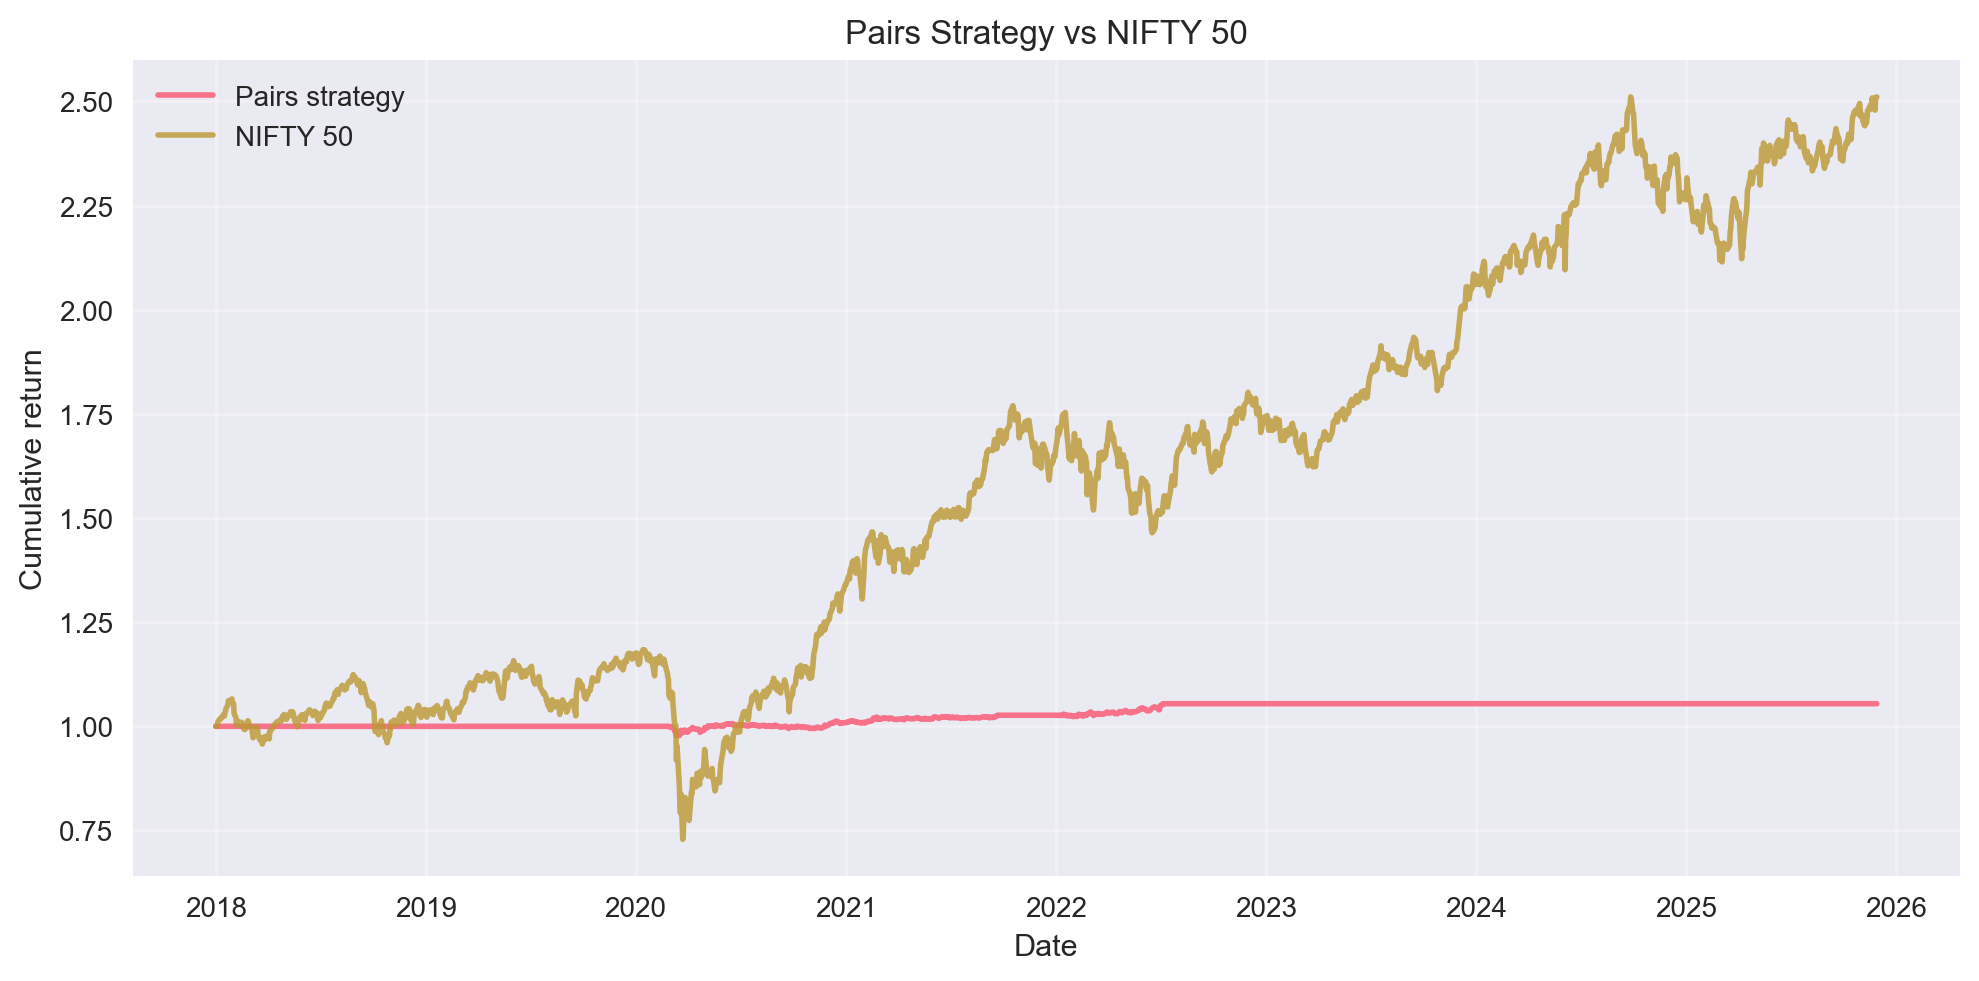

In [97]:
# Cumulative PnL vs NIFTY
plt.figure(figsize=(10, 5))

plt.plot(signals.index, signals["cumulative_returns"],
         label="Pairs strategy", linewidth=2)
plt.plot(nifty_cumulative.index, nifty_cumulative,
         label="NIFTY 50", linewidth=2, alpha=0.8)

plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("Pairs Strategy vs NIFTY 50")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

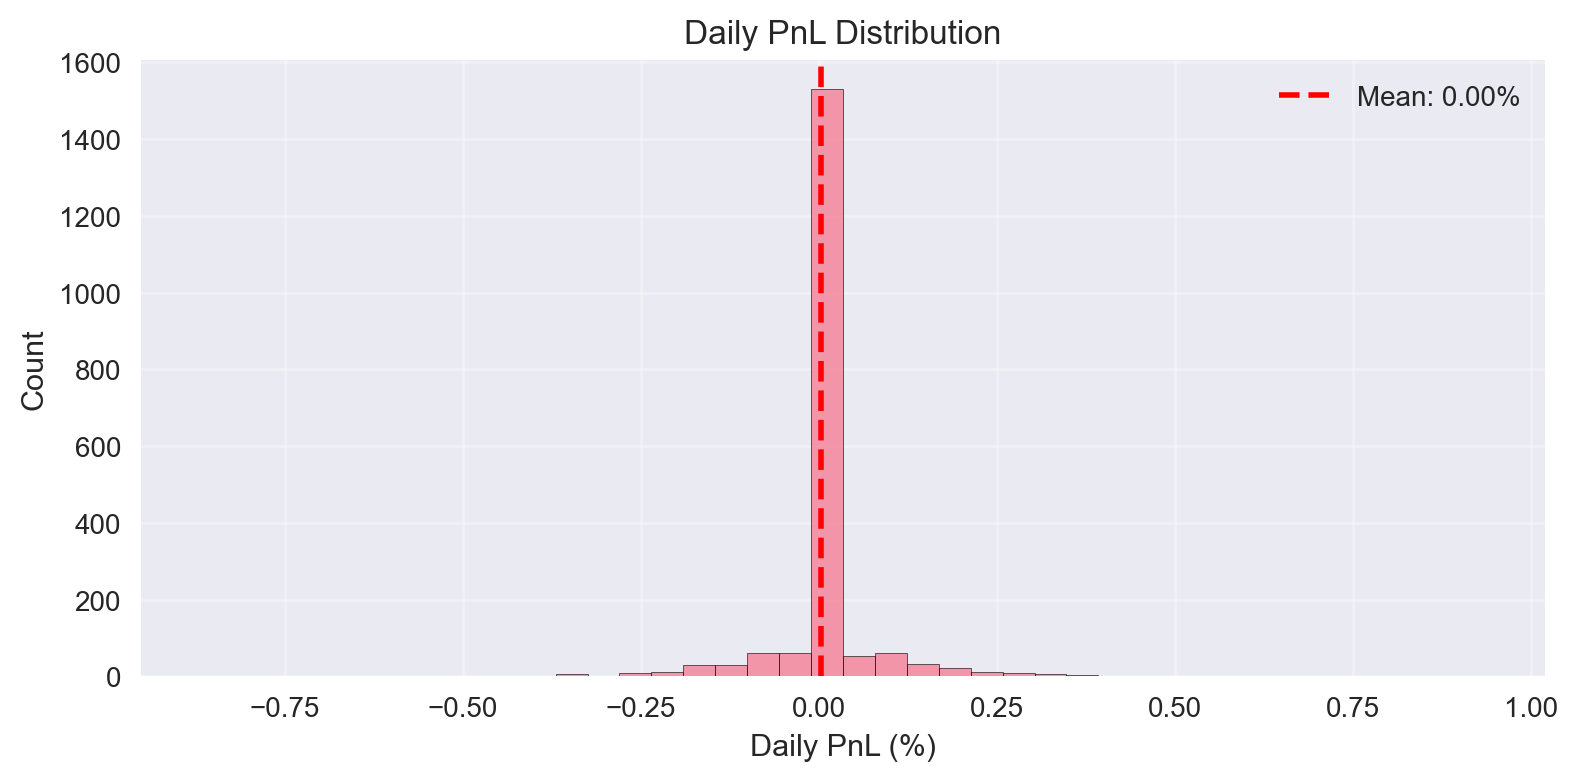

In [98]:
# Daily PnL distribution
plt.figure(figsize=(8, 4))
pnls = signals["pnl_net"].dropna() * 100  # in %

plt.hist(pnls, bins=40, edgecolor="black", alpha=0.7)
plt.axvline(pnls.mean(), color="red", linestyle="--", linewidth=2,
            label=f"Mean: {pnls.mean():.2f}%")

plt.xlabel("Daily PnL (%)")
plt.ylabel("Count")
plt.title("Daily PnL Distribution")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

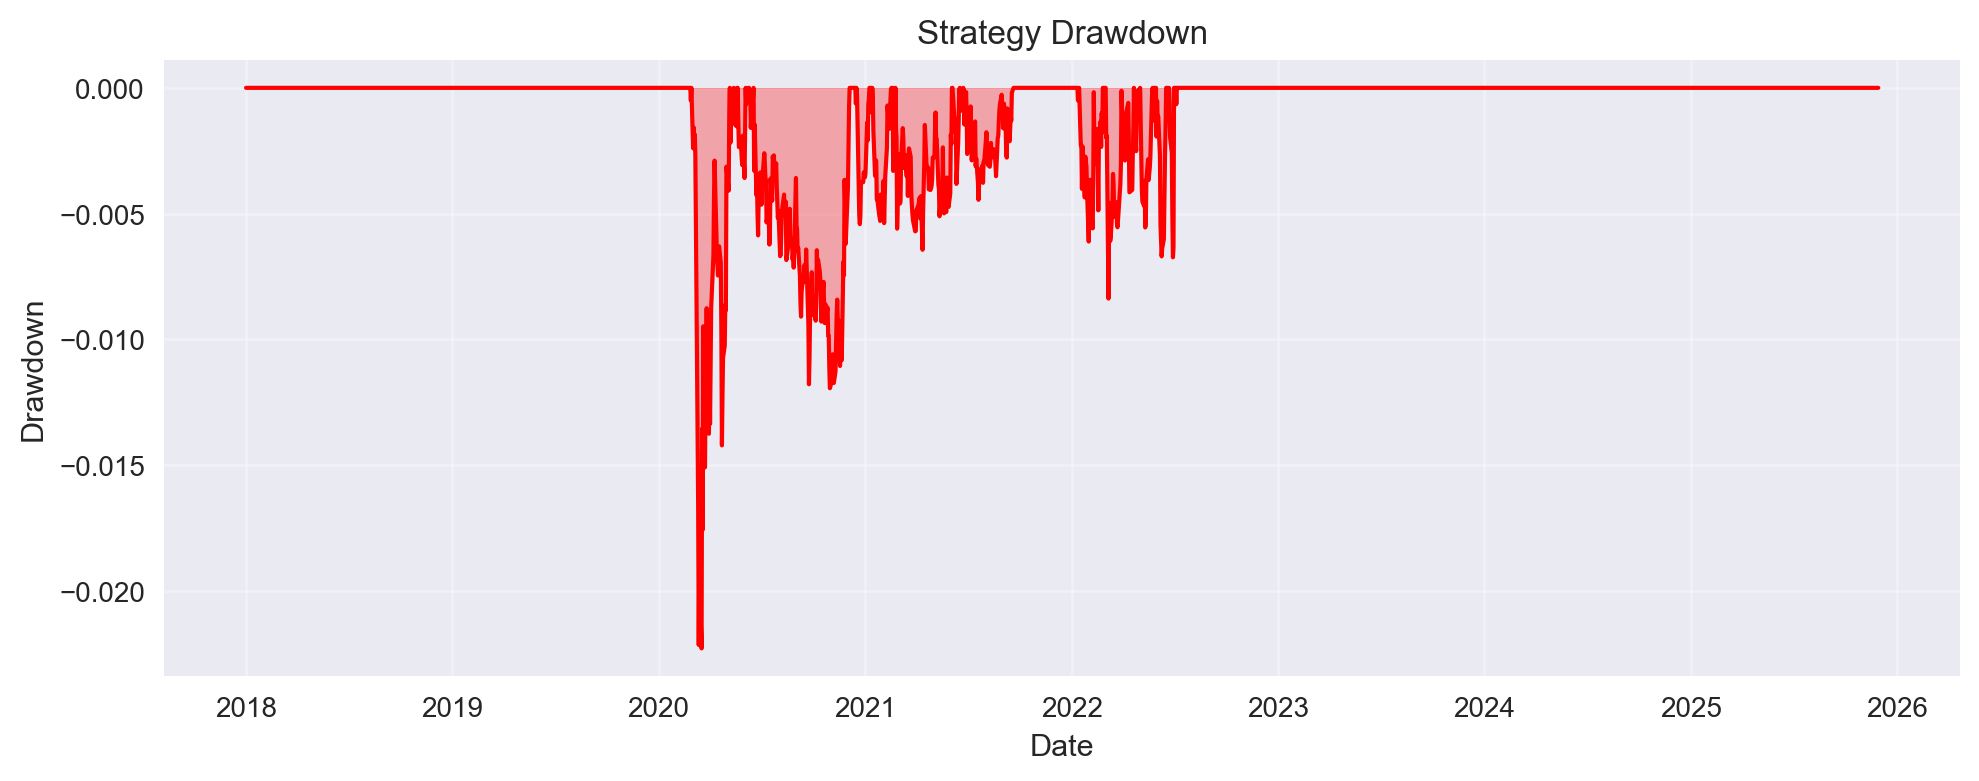

In [99]:
# Drawdown
drawdown = signals["cumulative_returns"] / signals["cumulative_returns"].cummax() - 1

plt.figure(figsize=(10, 4))
plt.plot(drawdown.index, drawdown, color="red", linewidth=1.5)
plt.fill_between(drawdown.index, drawdown, 0, color="red", alpha=0.3)

plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.title("Strategy Drawdown")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Signal Visualization & Position Sizing

**Entry/exit markers** plotted on z-score:
- **Dashed lines:** ±2σ entry thresholds
- **Dotted lines:** ±0.5σ exit thresholds

**Position sizing** shows vol-adjusted exposure over time, confirming risk management.


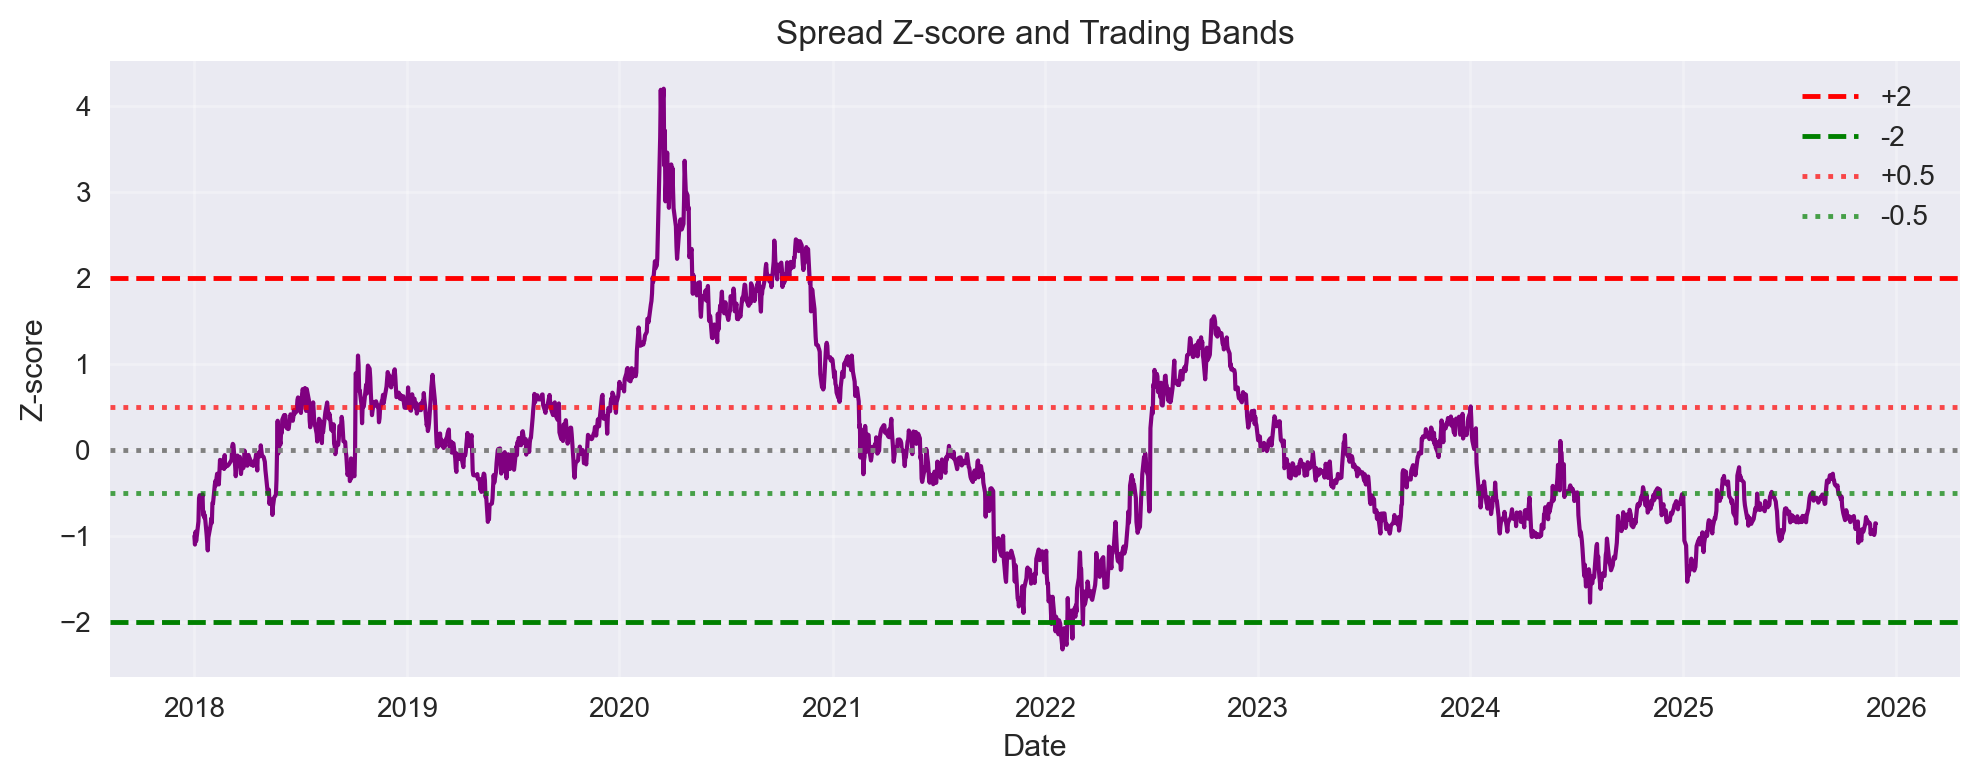

In [100]:
# Spread Z‑Score and Trading Bands
plt.figure(figsize=(10, 4))

plt.plot(signals.index, signals["zscore"], color="purple", linewidth=1.5)
plt.axhline(0, color="gray", linestyle=":")
plt.axhline(2, color="red", linestyle="--", label="+2")
plt.axhline(-2, color="green", linestyle="--", label="-2")
plt.axhline(0.5, color="red", linestyle=":", alpha=0.7, label="+0.5")
plt.axhline(-0.5, color="green", linestyle=":", alpha=0.7, label="-0.5")

plt.ylabel("Z-score")
plt.xlabel("Date")
plt.title("Spread Z-score and Trading Bands")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

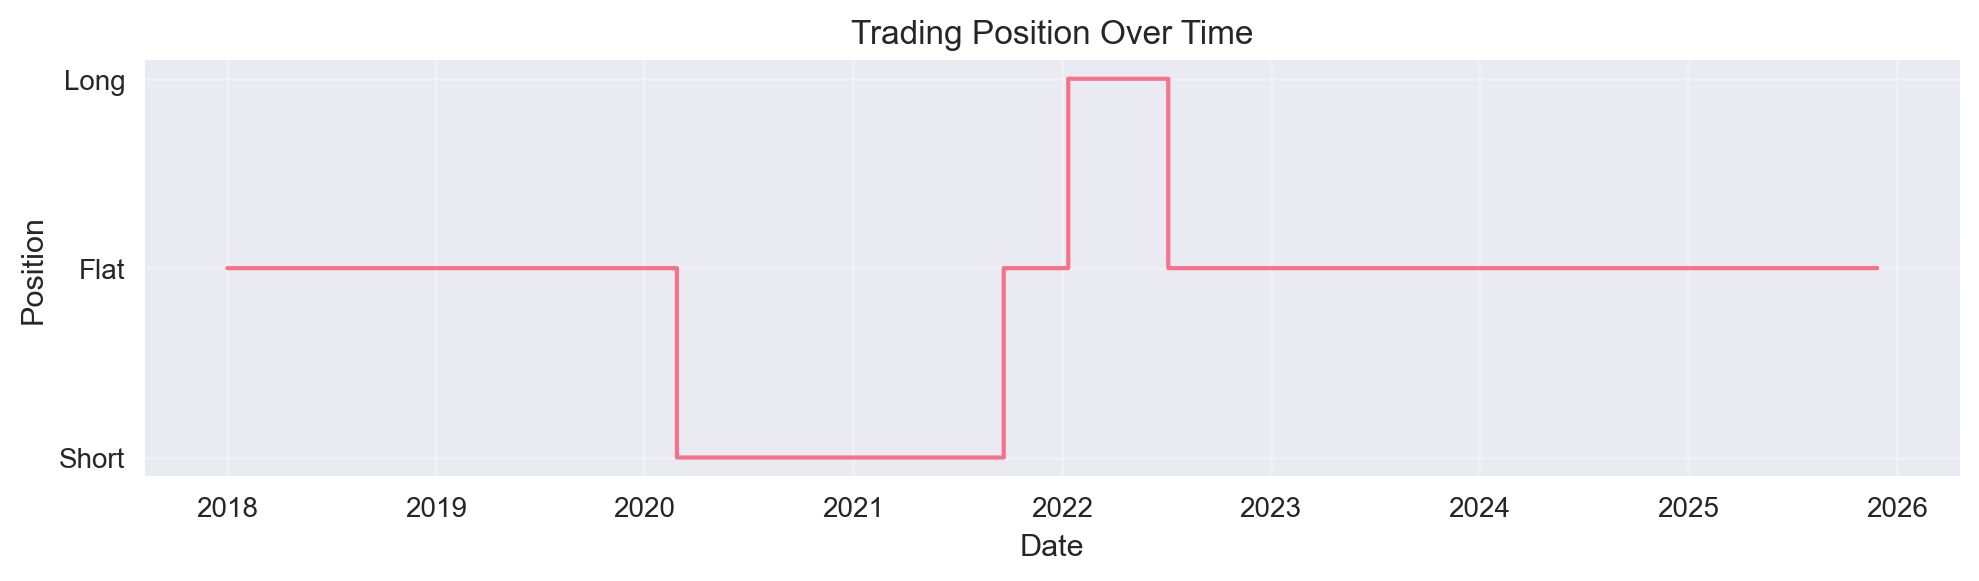

In [101]:
# Trading Position Over Time
plt.figure(figsize=(10, 3))

plt.step(signals.index, signals["position"], where="post", linewidth=1.5)
plt.ylabel("Position")
plt.xlabel("Date")
plt.yticks([-1, 0, 1], ["Short", "Flat", "Long"])
plt.title("Trading Position Over Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Conclusion & Key Takeaways

This project implements a **cointegration-based pairs trading strategy** on NIFTY 50 constituents using Engle-Granger testing, OLS hedge ratios, and z‑score based mean‑reversion signals. The strategy is fully market‑neutral, trading only when the spread between a cointegrated pair deviates significantly from its long‑run equilibrium.

Over 7 years of daily data (2018–2025), the strategy achieved **0.68% annualized return** with a **Sharpe ratio of 0.51**, **max drawdown of −2.23%**, and only **4 high‑conviction trades**, compared to a **~20% annualized return for NIFTY 50 buy‑and‑hold**. This highlights a **low‑volatility, low‑drawdown profile** consistent with conservative statistical arbitrage rather than benchmark outperformance.

The project demonstrates the full pipeline for a real‑world quant strategy: universe selection, data cleaning, cointegration screening, hedge‑ratio estimation, signal generation, backtesting with realistic transaction costs, and performance/risk visualization. The codebase is designed to be easily extensible to multiple pairs, alternative entry/exit rules, and portfolio‑level capital allocation.
